# JWST NIRISS SIRS Correction

Bernard.J.Rauscher@nasa.gov<br>
27 July 2021

This example shows how to SIRS correct JWST NIRISS full-frame data using a previously computed SIRS calibration file. Chris Willott of the NIRISS team specified which files to use in an email dated 26 July 2021. The data set consisted of 48 sampled up-the-ramp darks, each having 100 frames. I used the first half of these as training data. The second half, sorted by observation start time (24 files), can be used to test SIRS.

## 1. Load Previously Computed Calibration file.

We start by plotting the $\alpha$ and $\beta$ vectors inferred from the training data. SIRS does this in Julia. We do not provide a python module for computing these vectors. The operations are computationally intensive.

In [2]:
# Standard python packages
from glob import glob
from astropy.io import fits
import pandas as pd
import numpy as np
from os import getenv
import matplotlib.pyplot as plt

import sirspy

In [3]:
# Instantiate a SIRS object
sirs = sirspy.SIRS(getenv('HOME') +\
            '/Library/'+'JWST/NIRISS/20210726_niriss_sirs_first-24.jld')

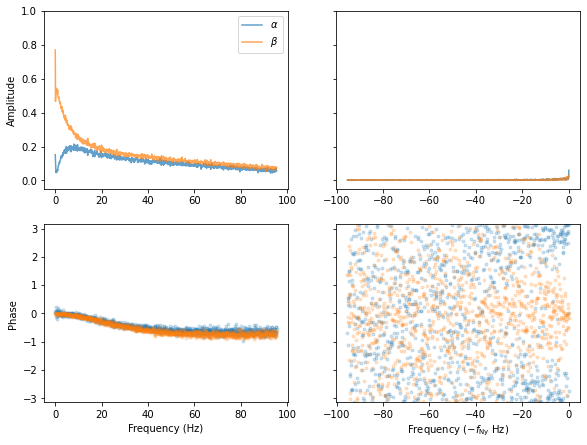

In [4]:
# Make some plots to show that it imported correctly. NIRISS's outputs are
# numbered 0-3 in SIRS.
output = 1 # Select an output
sirs.plot(output, mag=1.5); # Plot it

## 2. SIRS Correct One File

The file names do not naturally sort by time. We therefore need a little helper function to sort filenames by integration start time.

In [5]:
def sort_fits(files):
    """
    Sort a list of FITS files by integration start time
    
    Parameters: files, list
                  A list of FITS files to sort
    """
    # Tabulate pathnames and timestamps
    ts = []
    for file in files:    
        with fits.open(file) as hdul:
            _ts = hdul[0].header['DATE-OBS']+'T'+hdul[0].header['TIME-OBS']
            _ts = pd.to_datetime(_ts)
            ts.append(_ts)
        
    # Create a pandas DataFrame
    df = pd.DataFrame({'File':pd.Series(files), 'TS':pd.Series(ts)})
    
    # Sort by time
    df = df.sort_values('TS')
    
    # Done
    return(df['File'].values)

Reference correct one that was not part of the training data set.

In [6]:
# Make a time sorted list of files. The last 24 were excluded from the training set.
# These can be used to test SIRS.
files = sort_fits(glob('/local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/*.fits'))[-24:]

In [7]:
# Pick one from the list
file = files[0]

In [8]:
# Get data and convert to float
with fits.open(file) as hdul:
    D = np.float64(hdul[0].data)

In [9]:
# Reference correct
sirs.refcor(D)

## 3. "Slope Fitting" the SIRS Corrected Cube

In [10]:
Λ = sirspy.LegFit(100,1) # 100 samples up-the-ramp, 1st degree fit

In [11]:
λ = Λ.fit(D)

In [12]:
fits.PrimaryHDU(λ).writeto(getenv('HOME')+'/tmp/myfit.fits', overwrite=True)

## 4. "Slope Fit" them all and save just the slope  images.

The units are DN.

In [14]:
# SIRS correct and fit last 24
result = np.zeros((len(files),2048,2048), dtype=np.float)
for i in np.arange(len(files)):
    print('Processing file: ', files[i])

    # Get data
    with fits.open(files[i]) as hdul:
        D = np.float64(hdul[0].data)
        
    # SIRS correct. SIRS works in place.
    sirs.refcor(D)
    
    # Fit straight lines
    result[i] = 2*(Λ.fit(D))[1] # Save just the slope. The
                                # factor of 2x converts to
                                # integrated DN.
            
fits.PrimaryHDU(result).writeto(getenv('HOME')+'/tmp/20210727_niriss_sirs_counts.fits')

Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_1_496_SE_2016-01-07T21h04m49.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_2_496_SE_2016-01-07T21h25m50.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_3_496_SE_2016-01-07T21h44m12.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_4_496_SE_2016-01-07T22h03m01.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_5_496_SE_2016-01-07T22h20m00.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_6_496_SE_2016-01-07T22h38m49.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_7_496_SE_2016-01-07T22h58m29.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_

In [13]:
# Rowsonly correct and fit last 24
result = np.zeros((len(files),2048,2048), dtype=np.float)
for i in np.arange(len(files)):
    print('Processing file: ', files[i])

    # Get data
    with fits.open(files[i]) as hdul:
        D = np.float64(hdul[0].data)
        
    # Rows only correct. This also works in place.
    sirs.refcor(D, rowsonly=True)
    
    # Fit straight lines
    result[i] = 2*(Λ.fit(D))[1] # Save just the slope. The
                                # factor of 2x converts to
                                # integrated DN.
            
fits.PrimaryHDU(result).writeto(getenv('HOME')+'/tmp/20210727_niriss_rows_counts.fits')

Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_1_496_SE_2016-01-07T21h04m49.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_2_496_SE_2016-01-07T21h25m50.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_3_496_SE_2016-01-07T21h44m12.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_4_496_SE_2016-01-07T22h03m01.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_5_496_SE_2016-01-07T22h20m00.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_6_496_SE_2016-01-07T22h38m49.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_Darks_Willott/NISNIRISSDARK-160072041_7_496_SE_2016-01-07T22h58m29.fits
Processing file:  /local/data/racy1/brausche/JWST/NIRISS/SIRS_

In [14]:
np.median(result[:,4:-4,4:-4])

26.602538520126487